### Import libraries and read in file

In [195]:
# import libs
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# models and stuff
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [196]:
# read in file and define some useful column groupings
elec_w_weather_path = '/users/ianmyjer/desktop/disagg/electric_data_with_weather.csv'
df = pd.read_csv(elec_w_weather_path,delimiter=',',header=0,index_col=0,parse_dates=True)

In [197]:
# define useful column groupings
power_cols = ['north_br','south_br','basement','dryer','washer',
'dining_room','dishwasher','workbench','security_system',
'refrigerator','furnace_fan','garage','heat_pump',
'dhw_heater','main_house_total','office','outside_plug',
'rental_suite','entertainment','utility_room','unmetered',
'whole_house_total','oven']
weather_cols = ['Temp (C)', 'Dew Point Temp (C)', 'Rel Hum (%)', 
'Wind Spd (km/h)','Stn Press (kPa)']

## Features

In [198]:
def feature_creation(df):
    # time-based features
    df['dow'] = df.index.weekday
    df['weekday'] = (df.index.weekday < 5)*1
    df['business_hours'] = (df.index.weekday < 5)&(df.index.hour>=9)&(df.index.hour<=17)*1
    df['hour'] = df.index.hour

    # season dummies
    df['winter'] = (df.index.month<=3)*1
    df['spring'] = (df.index.month>3)&(df.index.month<=6)*1
    df['summer'] = (df.index.month>6)&(df.index.month<=9)*1
    df['fall'] = (df.index.month>9)*1

    # main house power percentage change and diff
    for interval in [1,3,5,9,15]:
        df['mht_pct_'+str(interval)] = df['main_house_total'].pct_change(freq='1Min').fillna(0).replace(np.inf,1000)
        df['pos_mht_diff_'+str(interval)] = df['main_house_total'].diff(periods=1).fillna(0)
    
    # rolling stats
    for time_val in [15,30,60,120,240,480]:
        df['rolling_sum_'+str(time_val)] = df['main_house_total'].rolling(time_val).sum().fillna(0)
        df['rolling_mean_'+str(time_val)] = df['main_house_total'].rolling(time_val).mean().fillna(0)
        df['rolling_max_'+str(time_val)]  = df['main_house_total'].rolling(time_val).max().fillna(0)
        df['rolling_min_'+str(time_val)]  = df['main_house_total'].rolling(time_val).min().fillna(0)
        df['rolling_median_'+str(time_val)]  = df['main_house_total'].rolling(time_val).median().fillna(0)

    # create list of all features starting with "Fall"
    feature_cols = list(df.columns[list(df.columns).index('fall'):])
    feature_cols.extend(['main_house_total','dow','hour','summer','spring','Temp (C)','Rel Hum (%)'])
    return df, feature_cols

df, feature_cols = feature_creation(df)

### Category 2 - ON/OFF Rooms
Rooms with switches that can be turned ON/OFF (lights, phone chargers, etc.)

When room is in use, power change is incremental and relatively small. For example, a bedroom could have a light turned on or a phone plugged in, but any increase or decrease in power would be small as compared to a dishwasher or dryer.

When all switches OFF, power may not be 0 due to plug loads (alarm clocks, safety lights, etc.)

Hypothesis: If I could accurately classify a simple load like dining room, I could use that model to make the other ones a lot better. This one might work well because it has obvious peaks at night when everyone sits down for dinner

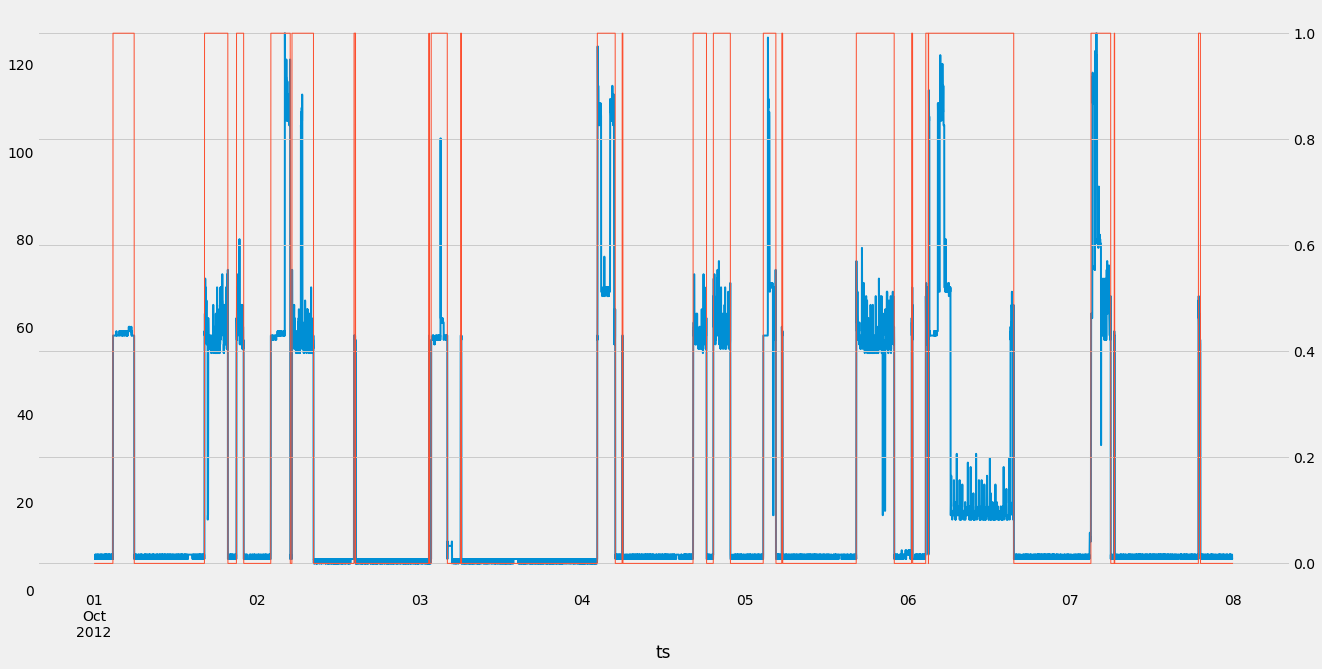

In [174]:
# categorize rooms using basic logic
thresh = 15
lbl = 'south_br'
df[lbl+'_on'] = df[lbl].apply(lambda x: 1 if x > thresh else 0)
    
# plot to see if it makes sense
mask = (df.index.year==2012)&(df.index.week==40) # &(df.index.day==12)
df[lbl][mask].plot(linewidth=2,figsize=(20,10));
df[lbl+'_on'][mask].plot(secondary_y=True,linewidth=1,figsize=(20,10));

In [ ]:
def tts(X,y):
    train_size = int(len(X) * 0.66)
    X_train, X_test = X[0:train_size], X[train_size:len(X)]
    y_train, y_test = y[0:train_size], y[train_size:len(X)]
    return X_train, X_test, y_train, y_test

In [ ]:
def model_chooser(model_type):
    if model_type == 'random forest':
        model = RandomForestClassifier()
    elif model_type == 'logistic regression':
        model = LogisticRegression()
    elif model_type == 'decision tree':
        model = DecisionTreeClassifier()

    # fit and predict on model
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:,1]
    
    return model, y_pred, y_pred

In [199]:
def categorize_rooms(df,lbl,feature_cols,model_type='random forest',thresh=15):
    df[lbl+'_on'] = df[lbl].apply(lambda x: 1 if x > thresh else 0)
    
    # define X, y
    X = df[feature_cols]
    y = df[lbl+'_on']

    # basic train test split for time series
    train_size = int(len(X) * 0.66)
    X_train, X_test = X[0:train_size], X[train_size:len(X)]
    y_train, y_test = y[0:train_size], y[train_size:len(X)]

    # use proper model
    if model_type == 'random forest':
        model = RandomForestClassifier()
    elif model_type == 'logistic regression':
        model = LogisticRegression()
    elif model_type == 'decision tree':
        model = DecisionTreeClassifier()
    

    
    print(lbl)
    # Predict appliances are always OFF
    y_null = np.zeros(len(y_test))
    print('Null Accuracy Score:', metrics.accuracy_score(y_test, y_null))

    # total accuracy
    print('Total Accuracy Score:', metrics.accuracy_score(y_test, y_pred))
    print('Log Loss:', metrics.log_loss(y_test,y_pred_proba))

    # binary accuracy
    print('Accuracy Score 1s:', metrics.accuracy_score(y_test[y_test==1], y_pred[y_test==1]))
    print('Accuracy Score 0s:', metrics.accuracy_score(y_test[y_test==0], y_pred[y_test==0]))

    return model

In [ ]:
# model = categorize_rooms(df,'south_br',feature_cols)
# pd.DataFrame(list(zip(feature_cols,model.feature_importances_))).sort_values(by=1,ascending=False);

## Category 1 - ON/OFF Appliances
Appliances that are either OFF and have 0 power draw or ON and have high power draw

In [200]:
# classify power_on based only on power > 0
on_off_apps = ['dishwasher', 'oven', 'dryer', 'washer']
for lbl in on_off_apps:
    df[lbl+'_on'] = df[lbl].apply(lambda x: 1 if x > 0 else 0)
    
df['any_on_off_app_on'] = np.where(df[of_apps].sum(axis=1) >= 1, 1, 0)

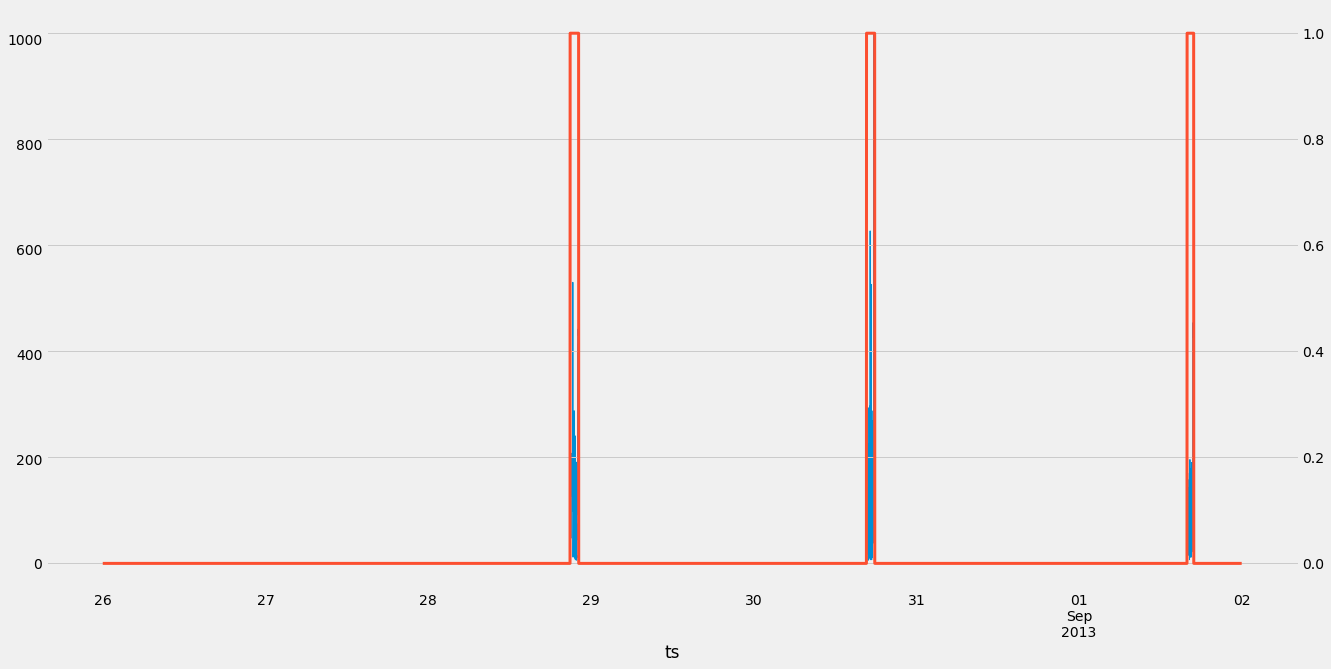

In [201]:
# plot to see if it makes sense
lbl = 'washer'
mask = (df.index.week==35)&(df.index.year==2013) # &(df.index.day==12)
df[lbl][mask].plot(linewidth=1,figsize=(20,10));
df[lbl+'_on'][mask].plot(secondary_y=True,linewidth=3,figsize=(20,10));

In some cases this methodology shows appliances turning on when they are not actually on (if power meter registers a non zero load for whatever reason). The methodology also shows appliances turning off midway through their usage (e.g., If the dishwasher has a small "off" period mid cycle) however, it seems like this basic methodology determines the power ON/OFF accurately most of the time (based on visual inspection).

I may need to revisit this if turns out to be whack. It would also be nice if I could quantify the accuracy of this methodology.

### Basic Classification Model

In [202]:
def categorize_appliance(df,y_label,x_label,feature_cols,model_type='logistic regression'):    
    model = categorize_rooms(df,x_label,feature_cols,model_type=model_type)
    df[x_label+'_on'] = model.predict(df[feature_cols])
    
    feature_cols.append('south_br_on')
    
    # define X, y
    X = df[feature_cols]
    y = df[y_label+'_on']

    # basic train test split for time series
    train_size = int(len(X) * 0.66)
    X_train, X_test = X[0:train_size], X[train_size:len(X)]
    y_train, y_test = y[0:train_size], y[train_size:len(X)]

    if model_type == 'random forest':
        model = RandomForestClassifier()
    elif model_type == 'logistic regression':
        model = LogisticRegression()
    elif model_type == 'decision tree':
        model = DecisionTreeClassifier()
        
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:,1]
    
# pd.DataFrame(list(zip(feature_cols,model.feature_importances_))).sort_values(by=1,ascending=False);
    
    print(y_label)
    # Predict appliances are always OFF
    y_null = np.zeros(len(y_test))
    print('Null Accuracy Score:', metrics.accuracy_score(y_test, y_null))

    # total accuracy
    print('Total Accuracy Score:', metrics.accuracy_score(y_test, y_pred))
    print('Log Loss:', metrics.log_loss(y_test,y_pred_proba))

    # binary accuracy
    print('Accuracy Score 1s:', metrics.accuracy_score(y_test[y_test==1], y_pred[y_test==1]))
    print('Accuracy Score 0s:', metrics.accuracy_score(y_test[y_test==0], y_pred[y_test==0]))

    return model

# model = categorize_rooms(df,'south_br',feature_cols)

In [203]:
model = categorize_appliance(df,'any_on_off_app','south_br',feature_cols,model_type='random forest')

south_br
Null Accuracy Score: 0.7115902436839777
Total Accuracy Score: 0.7993623798514272
Log Loss: 0.5674606254401262
Accuracy Score 1s: 0.5018196993371442
Accuracy Score 0s: 0.9199573609412061
any_on_off_app
Null Accuracy Score: 0.8868965980529914
Total Accuracy Score: 0.9171625623485022
Log Loss: 0.6769596580371445
Accuracy Score 1s: 0.32359928726984755
Accuracy Score 0s: 0.992857999482418


In [193]:
pd.DataFrame(list(zip(feature_cols,model.feature_importances_))).sort_values(by=1,ascending=False)

,0,1
13,rolling_max_15,0.230745
36,Temp (C),0.049308
18,rolling_max_30,0.049176
30,rolling_median_120,0.045150
28,rolling_max_120,0.043224
33,hour,0.041878
25,rolling_median_60,0.041140
29,rolling_min_120,0.039967
23,rolling_max_60,0.039169
19,rolling_min_30,0.034273


In [ ]:
# define X, y
X = df[feature_cols]
y = df['dishwasher_on']

# basic train test split for time series
train_size = int(len(X) * 0.66)
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(X)]

In [ ]:
# Predict appliances are always OFF
y_null = np.zeros(len(y_test))
print('Accuracy Score:', metrics.accuracy_score(y_test, y_null))
print('Log Loss:', metrics.log_loss(y_test,y_null))

In [ ]:
# fit Random Forest
forest = RandomForestClassifier(n_estimators=30,max_features=10)
forest.fit(X_train,y_train)
y_pred = forest.predict(X_test)
y_pred_proba = forest.predict_proba(X_test)

In [ ]:
pd.DataFrame(list(zip(feature_cols,forest.feature_importances_))).sort_values(by=1,ascending=False);

In [ ]:
print('Accuracy Score:', metrics.accuracy_score(y_test, y_pred))
print('Log Loss:', metrics.log_loss(y_test,y_pred_proba))

In [ ]:
print('Accuracy Score 1s:', metrics.accuracy_score(y_test[y_test==1], y_pred[y_test==1]))
print('Accuracy Score 0s:', metrics.accuracy_score(y_test[y_test==0], y_pred[y_test==0]))

In [ ]:
# # fit a Logistic Regression
# logreg = LogisticRegression()
# logreg.fit(X_train, y_train)
# y_pred = logreg.predict(X_test)
# y_pred_proba = logreg.predict_proba(X_test)[:,1]

In [ ]:
# print('Accuracy Score:', metrics.accuracy_score(y_test, y_pred))
# print('Log Loss:', metrics.log_loss(y_test,y_pred_proba))

In [ ]:
# # fit Decision Tree
# tree = DecisionTreeClassifier()
# tree.fit(X_train,y_train)
# y_pred = tree.predict(X_test)
# y_pred_proba = tree.predict_proba(X_test)

In [ ]:
# print('Accuracy Score:', metrics.accuracy_score(y_test, y_pred))
# print('Log Loss:', metrics.log_loss(y_test,y_pred_proba))

In [ ]:
# My computer is too slow to run these tuning plots so I just guessed:
# estimator_range = [10,150,300]

# accuracy_scores = []
# for n in estimator_range:
#     forest = RandomForestClassifier(n_estimators=n,random_state=420)
#     forest.fit(X_train,y_train)
#     accuracy_scores.append(metrics.accuracy_score(y_test,forest.predict(X_test)))

In [ ]:
# plt.plot(estimator_range, accuracy_scores)
# plt.xlabel('n_estimators')
# plt.ylabel('Accuracy Score')

In [ ]:
# feature_range = range(1,len(feature_cols)+1)
# accuracy_scores = []
# for n in feature_range:
#     forest = RandomForestClassifier(n_estimators=XXX, max_features=n, random_state=420)
#     forest.fit(X_train,y_train)
#     accuracy_scores.append(metrics.accuracy_score(y_test,forest.predict(X_test)))

### Category 3: On-Demand Appliances

Appliances that turn on and off automatically based on demand

In [ ]:
od_apps = ['dhw_heater','refrigerator']

In [ ]:
lbl = 'dhw_heater'
mask = (df.index.week==33)&(df.index.year==2013)# &(df.index.day==12)
df[lbl][mask].plot(linewidth=1,figsize=(20,10));
# df[lbl+'_on'][mask].plot(secondary_y=True,linewidth=1,figsize=(20,10));

### Category 4: Weather dependent appliances

Appliances that run automatically and may draw power based on the outdoor weather

In [ ]:
wd_apps = ['furnace_fan','heat_pump']

In [ ]:
lbl = 'heat_pump'
mask = (df.index.month==10)&(df.index.year==2013)# &(df.index.day==12)
df[lbl][mask].plot(linewidth=1,figsize=(20,10));
df['Temp (C)'][mask].plot(secondary_y=True,linewidth=1,figsize=(20,10))
# df[lbl+'_on'][mask].plot(secondary_y=True,linewidth=1,figsize=(20,10));